In [1]:
import numpy as np
import pandas as pd
import rpy2
from fn import F
from biom import load_table
import skbio
from scipy.spatial.distance import braycurtis
from skbio.stats import composition
from skbio import diversity

%load_ext rpy2.ipython

A set $X$ endowed with a binary operator $\delta(a, b): {X}^{2} \rightarrow  \mathbb{R}$ is called a metric space, if

1. $\delta$ is symmetric, i.e. $\delta(a, b) = \delta(b, a)$ for any $a, b \in X$ 
2. $\delta$ satisfies the triangle inequality, i.e. $\delta(a, b) \le \delta(a, c) + \delta(b, c)$ for any $a, b, c \in X$
\end{enumerate}
3. all elements in $X$ are separable under $\delta$, i.e. $\delta(a, b) = 0 \iff a = b$ for any $a, b \in X$

A function $\delta \colon X \times X \to \mathbb{R}$ is a pseudometric (aka semimetric) if it satisfies conditions all but the last conditions. So the difference between a pseudometric and a metric is just that in a pseudometric distinct points may have distance $0$.

Given a binary tree with weighted edges and two probability distributions over the edges $A$ and $B$:

$$ 
{U}_{w}(A, B) = \frac{ 
    \sum^{n}_{i}{{b}_{i} \left | {}^{A}{p}_{i} - {}^{B}{p}_{i} \right |} 
}{ 
    \sum^{n}_{i}{{b}_{i}}
},
$$

where ${b}_{i}$ – is the weight (length) of the $i$-th edge, ${}^{A}{p}_{i}$ and ${}^{B}{p}_{i}$ are probabilities associated with the edge in $A$ and $B$ respectively. This function is widely used in computational ecology these days as a notion of phylogenetic distance between two samples.
Recently, a modification has been proposed, dubbed the information UniFrac

$$ 
{U}_{inf}(A, B) = \frac{ 
    \sum^{n}_{i}{{b}_{i} \left | {}^{A}{p}_{i}\log_{2}{{}^{A}{p}_{i}} - {}^{B}{p}_{i}\log_{2}{{}^{B}{p}_{i}} \right |} 
}{ 
    \sum^{n}_{i}{{b}_{i}}
},
$$

which obviously replaces raw probabilities with self-information in the edge-weight normalisation factor. 

Then, if we have any function $f \colon X \to \mathbb{R}$, we obtain a pseudometric $\delta_f$ by setting

$$\delta_f(x,y) = \lvert f(x) - f(y)\rvert\,.$$

It's not important that the codomain of the function is $\mathbb{R}$, if we have $g \colon X \to Y$ with $(Y,d)$ a pseudometric space, then

$$\delta_g(x,y) = d(g(x), g(y))$$

is a pseudometric on $X$. Condition 1 is satisfied since the range of a pseudometric consists of nonnegative real numbers, so $d(g(x), g(y)) \geqslant 0$. The symmetry - condition 3 - transfers from $d$ to $\delta_g$, and the triangle inequality also follows from the triangle inequality for $d$:

$$\delta_g(x,z) = d(g(x), g(z)) \leqslant d(g(x), g(y)) + d(g(y), g(z)) = \delta_g(x,y) + \delta_g(y,z)\,.$$

It is straightforward to verify that if $\delta$ is a pseudometric and $c \geqslant 0$ then $c\cdot \delta$ is a pseudometric too, and that the sum of pseudometrics (if we have a sum of infinitely many pseudometrics, we need to impose convergence constraints) is again a pseudometric, using the nonnegativity, symmetry, and triangle inequality for each term.

The UniFrac example is

$$U_{\ast}(A,B) = \sum_{i = 1}^n c_i \delta_{f_i}(A,B)$$

where

$$c_i = \frac{b_i}{\sum_{k = 1}^n b_k}$$

and $f_i(C) = {}^Cp_i$ in the first case, $f_i(C) = {}^Cp_i\cdot \log {}^Cp_i$ - with the convention $0 \cdot \log 0 = 0$ - in the second. Thus the triangle inequality holds for all such constructions.

In this construction, we obtain a metric if and only if for all $x \neq y$ there is an $i$ such that $d(g_i(x), g_i(y)) > 0$. Since we're using the metric $d(a,b) = \lvert a - b\rvert$ on the codomain, that is the case if and only if for all $x \neq y$ there is an $i$ with $g_i(x)  \neq g_i(y)$.


In [2]:
%%R

library(ape)
library(broom.mixed)
library(car)
library(dplyr)
library(ggfortify)
library(ggplot2)
library(ggrepel)
library(ggtree)
library(ggtern)
library(glmnet)
library(latex2exp)
library(philr)
library(phyloseq)
library(phytools)
library(reshape2)
library(tidyr)
library(vegan)

source('stat_util.R')


R[write to console]: Loading required package: carData

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:car’:

    recode


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: ggplot2

R[write to console]: ggtree v1.14.6  For help: https://guangchuangyu.github.io/software/ggtree

If you use ggtree in published research, please cite the most appropriate paper(s):

- Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data. Methods in Ecology and Evolution 2017, 8(1):28-36, doi:10.1111/2041-210X.12628

- Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for map

In [3]:
table = load_table('table_filt.biom')
counts = table.matrix_data.toarray().astype(int)
taxonomy = table.metadata_to_dataframe('observation')
metadata = table.metadata_to_dataframe('sample')

In [4]:
table

654 x 56 <class 'biom.table.Table'> with 19348 nonzero entries (52% dense)

In [40]:
mask = counts > 100
selected = (mask.sum(1) > 56 / 3)
counts_obs = counts[selected,:] + 1
taxonomy_obs = taxonomy[selected]
tips_obs = taxonomy_obs.index

with open('tree.nwk') as buffer:
    tree_sheared = skbio.read(buffer, format="newick", into=skbio.tree.TreeNode).shear(tips_obs)
    # label internal nodes
    tree_sheared.assign_ids()
    for node in tree_sheared.traverse():
        if not node.is_tip():
            node.name = f'n{node.id}' 
counts_obs.shape

(22, 56)

In [41]:
wunifrac_obs = diversity.beta_diversity(
    'weighted_unifrac', 
    counts_obs.T, 
    otu_ids=tips_obs, 
    tree=tree_sheared
).to_data_frame()

bray_obs = diversity.beta_diversity(
    braycurtis, 
    counts_obs.T
).to_data_frame()

In [42]:
# def aitchison_distance(a, b):
#     """
#     Compute the Aitchison distance beetween two vectors
#     """
#     return np.linalg.norm(
#        composition.clr(a) - composition.clr(b)
#     )

# aitchison_obs = diversity.beta_diversity(
#     aitchison_distance,
#     counts_obs,
#     validate=False
# ).to_data_frame()

In [43]:
%%R -i wunifrac_obs,bray_obs,metadata # ,aitchison_obs

print(adonis(as.dist(wunifrac_obs) ~ soil + plant, data=metadata, permutations=9999))
print(adonis(as.dist(bray_obs) ~ soil + plant, data=metadata, permutations=9999))
# print(adonis(as.dist(aitchison_obs) ~ soil, data=metadata, permutations=9999))


Call:
adonis(formula = as.dist(wunifrac_obs) ~ soil + plant, data = metadata,      permutations = 9999) 

Permutation: free
Number of permutations: 9999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
soil       1    2.7869 2.78688 126.348 0.56576  1e-04 ***
plant      2    0.9921 0.49603  22.488 0.20140  1e-04 ***
Residuals 52    1.1470 0.02206         0.23284           
Total     55    4.9259                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Call:
adonis(formula = as.dist(bray_obs) ~ soil + plant, data = metadata,      permutations = 9999) 

Permutation: free
Number of permutations: 9999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
soil       1    5.4606  5.4606  94.684 0.53892  1e-04 ***
plant      2    1.6730  0.8365  14.504 0.16511  1e-04 ***
Residuals 52    2.9990  0.0577         0.29597           
Total     55   10.132

In [ ]:
%%R 

x  <- data.frame(
  x1 = c( 0, 0, 1, 0.1, 0.6, 0.2 ),
  x2 = c( 0, 1, 0, 0.3, 0.2, 0.8 ),
  x3 = c( 1, 0, 0, 0.6, 0.2, 0.0 )
)

ggtern(data=x, aes(x2,x1,x3)) + 
   geom_mask() +
   geom_point(fill="red",shape=21,size=4) + 
   theme_bw() +
   theme_showarrows() +
   theme_clockwise()

In [ ]:
np.linalg.svd(np.cov(np.random.multinomial(10, composition.closure([10, 10, 10]), size=(10,)).T))

In [57]:
%%R

data <- import_biom(BIOMfilename='table.biom', 
                    treefilename='tree.nwk',
                    parseFunction=parse_taxonomy_greengenes) %>%
        transform_sample_counts(function(x) x + 1)

# binarise the tree and rename internal nodes
phy_tree(data) <- makeNodeLabel(
    multi2di(phy_tree(data)), method='number', prefix='b'
)

# what is the root node
name.balance(phy_tree(data), tax_table(data), 'b1')

# transform all samples (including bare soil samples) for visual inspection
# note: we've disabled weighting (by setting weights to 'uniform'), therefore this is canonical ILR.
transform.wcontrol <- philr(
    t(otu_table(data)), 
    phy_tree(data), 
    part.weights='uniform', 
    ilr.weights='uniform'
)

R[write to console]: Building Sequential Binary Partition from Tree...

R[write to console]: Building Contrast Matrix...

R[write to console]: Transforming the Data...

R[write to console]: Calculating ILR Weights...



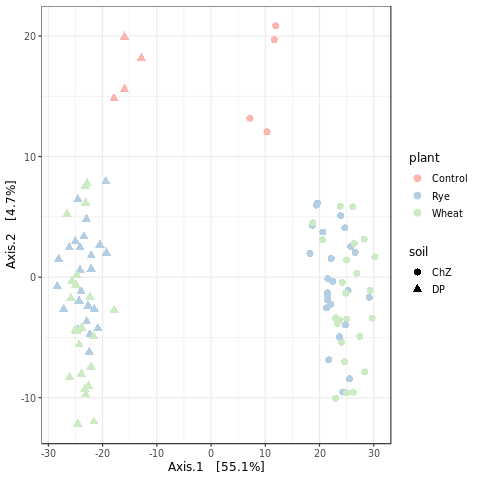

In [58]:
%%R

pcoa <- ordinate(data, 'PCoA', distance=dist(transform.wcontrol, method='euclidean'))
(plot.pcoa <- plot_ordination(data, pcoa, color='plant', shape='soil') + 
    geom_point(size=3) + 
    theme(text=element_text(size=11,  family='Helvetica')) +
    theme_bw() +
    scale_color_brewer(palette='Pastel1'))

In [59]:
%%R

# subset data
data.wplant <- subset_samples(data, sample_data(data)$plant != 'Control')

# extract observations, tree, taxonomy and metadata from the phyloseq object
observations.wplant <- t(otu_table(data.wplant))
tree.wplant <- phy_tree(data.wplant)
taxonomy.wplant <- tax_table(data.wplant)
meta.wplant <- sample_data(data.wplant)

transform.wplant <- philr(
    observations.wplant, 
    tree.wplant, 
    part.weights='uniform', 
    ilr.weights='uniform'
)

# add metadata to transforms
transform.wplant.wmeta <- as.data.frame(transform.wplant)
transform.wplant.wmeta$soil <- meta.wplant$soil
transform.wplant.wmeta$plant <- meta.wplant$plant
transform.wplant.wmeta$cultivar <- meta.wplant$cultivar
transform.wplant.wmeta$group <- paste(meta.wplant$plant, meta.wplant$soil, sep='@')


R[write to console]: Building Sequential Binary Partition from Tree...

R[write to console]: Building Contrast Matrix...

R[write to console]: Transforming the Data...

R[write to console]: Calculating ILR Weights...



In [52]:
%%R

ncol(transform.wplant)

[1] 653


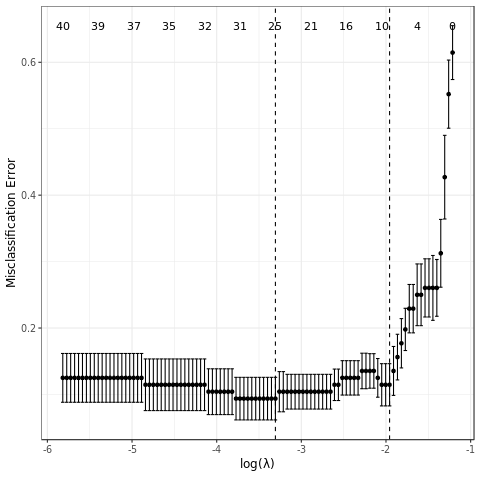

In [60]:
%%R

# cross-validation for l1 lambda parameter; standardise data before running cross-validation
cv.plant <- scale(transform.wplant) %>%
    cv.glmnet(meta.wplant$plant, alpha=1, family='binomial', type.measure='class')


(plot.cv <- autoplot(cv.plant) +
        xlab(TeX('$\\log(\\lambda)$')) + 
        theme(text=element_text(size=11,  family='Helvetica')) +
        theme_bw())



In [61]:
%%R

features.plant <- select.features(coef(cv.plant, s='lambda.min'))
features.plant

 [1] "b9"   "b19"  "b33"  "b44"  "b45"  "b51"  "b72"  "b92"  "b94"  "b116"
[11] "b141" "b142" "b234" "b265" "b327" "b394" "b435" "b468" "b496" "b500"
[21] "b542" "b551" "b622" "b642" "b650"


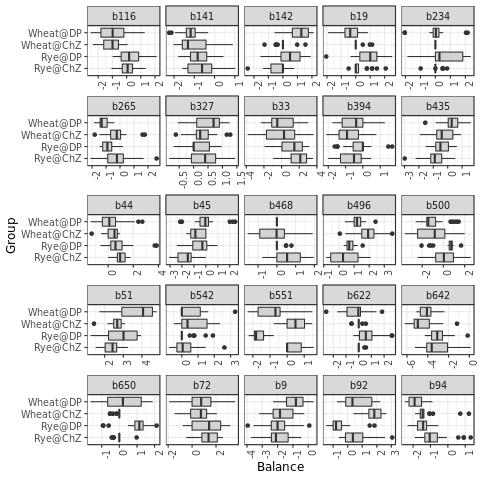

In [62]:
%%R

transform.wplant.long.plant <- transform.wplant %>%
    convert_to_long(get_variable(transform.wplant.wmeta, 'group')) %>%
    filter(coord %in% features.plant)

# consider openning the plot in a separate RStudio tab
ggplot(transform.wplant.long.plant, aes(x=labels, y=value)) +
    geom_boxplot(fill='lightgrey') +
    # scale_y_continuous(trans=signed.log1p.transform) +
    facet_wrap(.~coord, scales='free_x', ncol=5, nrow=8) +
    xlab('Group') + ylab('Balance') +
    theme_bw() + 
    theme(axis.text.x=element_text(angle=90, hjust=1)) + 
    coord_flip()
